# Introduction


## Data generation


PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

## Data structure

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# Analysis preparation


## Load packages

In [1]:
import numpy as np 
import sklearn
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Load the data

In [2]:
transactions = pd.read_csv("C:/Users/neave/Documents/unscript/data/AIML Dataset.csv")

## Glimpse the data

In [3]:
print(f"Data shape: {transactions.shape}")

Data shape: (6362620, 11)


In [4]:
transactions.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

# Data exploration

Let's start by checking for:

* columns names and types, and memory usage (info);
* aggregated functions for numerical values (describe);
* missing values;
* unique values.


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
transactions.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [8]:
missing_data(transactions)

step    type   amount nameOrig oldbalanceOrg newbalanceOrig  \
Total        0       0        0        0             0              0   
Percent    0.0     0.0      0.0      0.0           0.0            0.0   
Types    int64  object  float64   object       float64        float64   

        nameDest oldbalanceDest newbalanceDest isFraud isFlaggedFraud  
Total          0              0              0       0              0  
Percent      0.0            0.0            0.0     0.0            0.0  
Types     object        float64        float64   int64          int64

In [9]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [10]:
unique_values(transactions)

step     type   amount  nameOrig  oldbalanceOrg  newbalanceOrig  \
Total    6362620  6362620  6362620   6362620        6362620         6362620   
Uniques      743        5  5316900   6353307        1845844         2682586   

         nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
Total     6362620         6362620         6362620  6362620         6362620  
Uniques   2722362         3614697         3555499        2               2

## Visualization 

We continue with the distribution of the data (count plots for categorical values, values distribution for numerical values).

In [11]:
def plot_count(df, feature, title='', size=2.5):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.4f}%'.format(100*height/total),
                ha="center") 
    plt.show()


C:\Users\neave\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



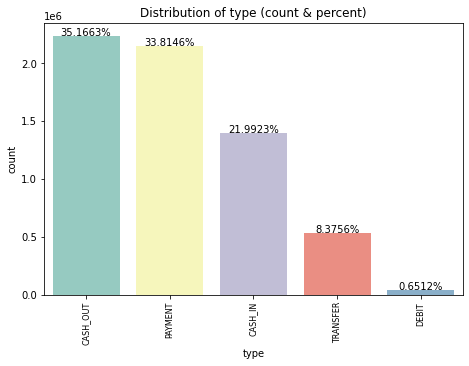

In [12]:
plot_count(transactions, 'type', 'Distribution of type (count & percent)', size=2.5)

C:\Users\neave\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



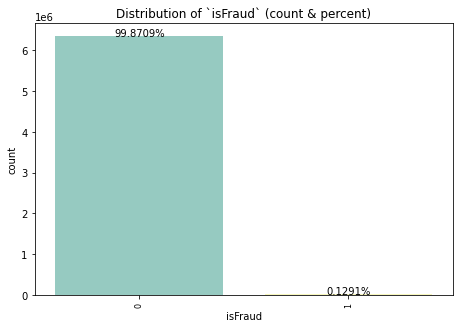

In [13]:
plot_count(transactions, 'isFraud', 'Distribution of `isFraud` (count & percent)', size=2.5)

C:\Users\neave\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



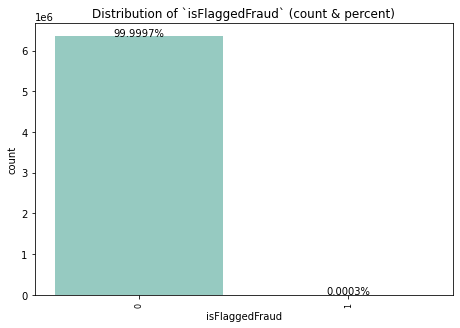

In [14]:
plot_count(transactions, 'isFlaggedFraud', 'Distribution of `isFlaggedFraud` (count & percent)', size=2.5)

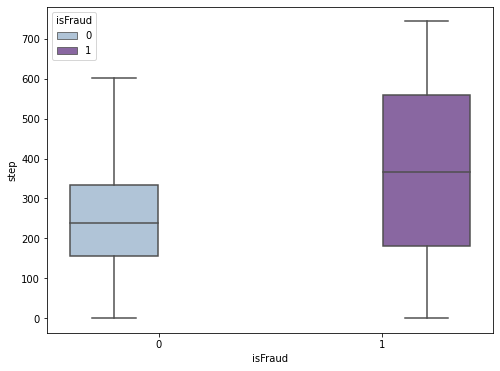

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
s = sns.boxplot(x="isFraud", y="step", hue="isFraud",data=transactions, palette="BuPu",showfliers=False)
plt.show()

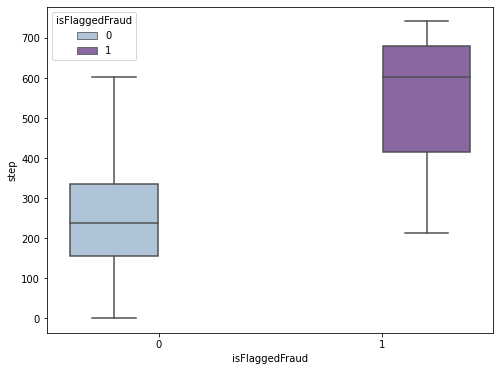

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
s = sns.boxplot(x="isFlaggedFraud", y="step", hue="isFlaggedFraud",data=transactions, palette="BuPu",showfliers=False)
plt.show()

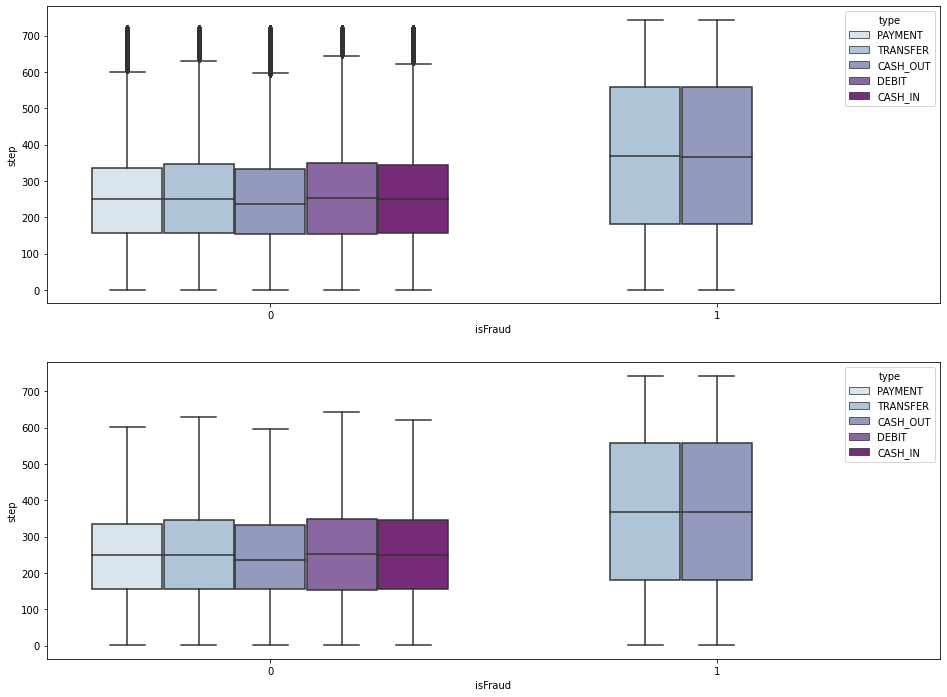

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="step", hue="type",data=transactions, palette="BuPu",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="step", hue="type",data=transactions, palette="BuPu",showfliers=False)
plt.show()

Hence we observe that frauds are being commited via 'CASH_OUT' and 'TRANSFER'

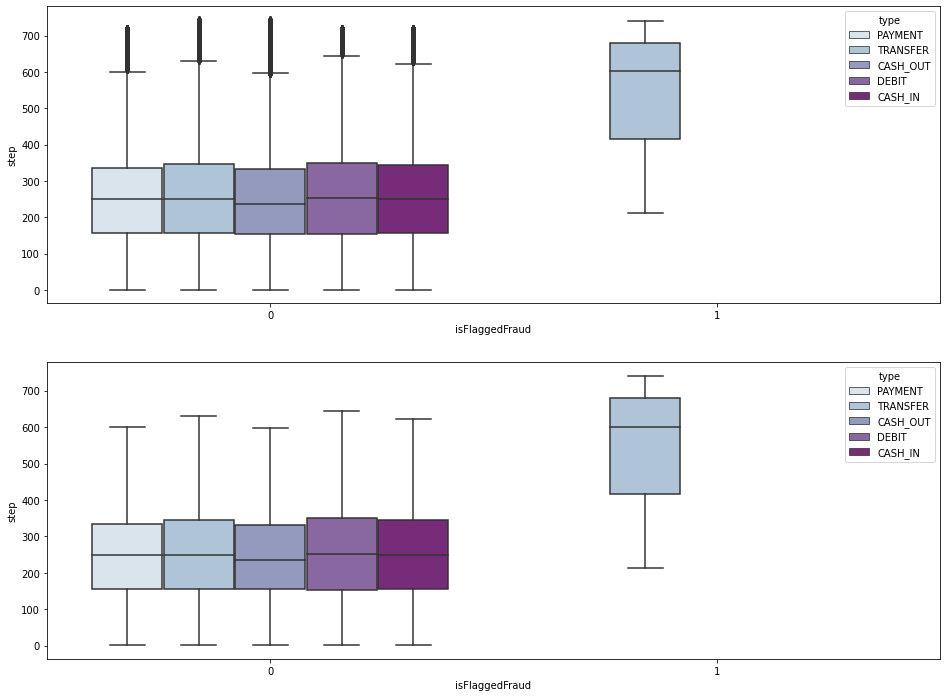

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFlaggedFraud", y="step", hue="type",data=transactions, palette="BuPu",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFlaggedFraud", y="step", hue="type",data=transactions, palette="BuPu",showfliers=False)
plt.show()

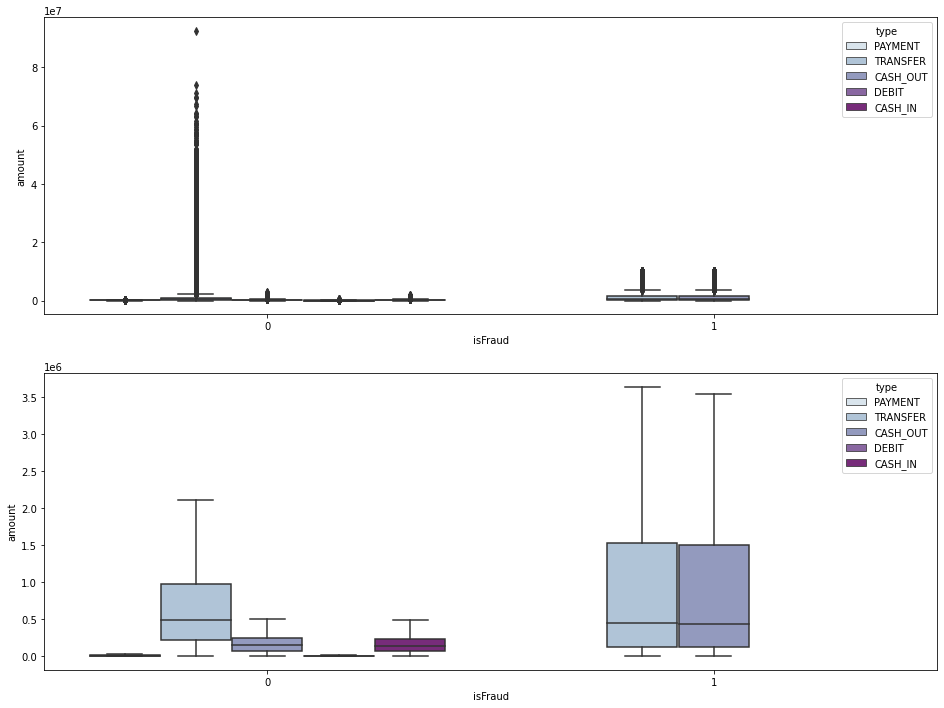

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="amount", hue="type",data=transactions, palette="BuPu",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="amount", hue="type",data=transactions, palette="BuPu",showfliers=False)
plt.show()

In [20]:
# Finding out the minimum and maximum transaction from Transfer and cash out transaction mode when it is set to be Fraud

print("TRANSFER Transaction")
print("Minimum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'TRANSFER')].amount.min())
print("Maximum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'TRANSFER')].amount.max())

print("\nCASH_OUT Transaction")
print("Minimum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'CASH_OUT')].amount.min())
print("Maximum Transaction :", transactions.loc[(transactions.isFraud == 1) & (transactions.type == 'CASH_OUT')].amount.max())

TRANSFER Transaction
Minimum Transaction : 63.8
Maximum Transaction : 10000000.0

CASH_OUT Transaction
Minimum Transaction : 0.0
Maximum Transaction : 10000000.0


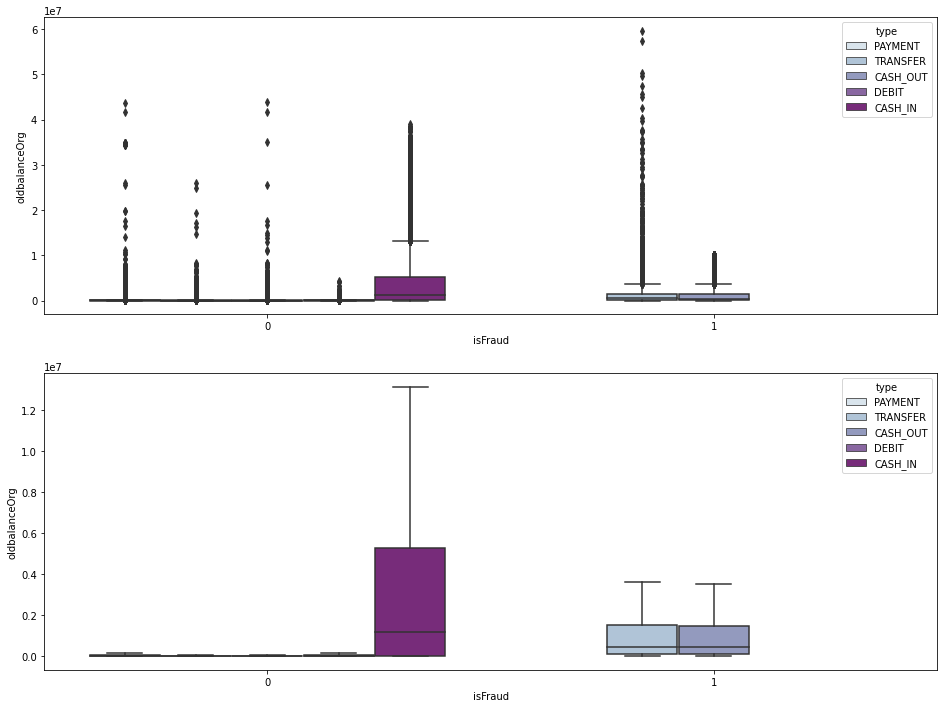

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="oldbalanceOrg", hue="type",data=transactions, palette="BuPu",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="oldbalanceOrg", hue="type",data=transactions, palette="BuPu",showfliers=False)
plt.show()

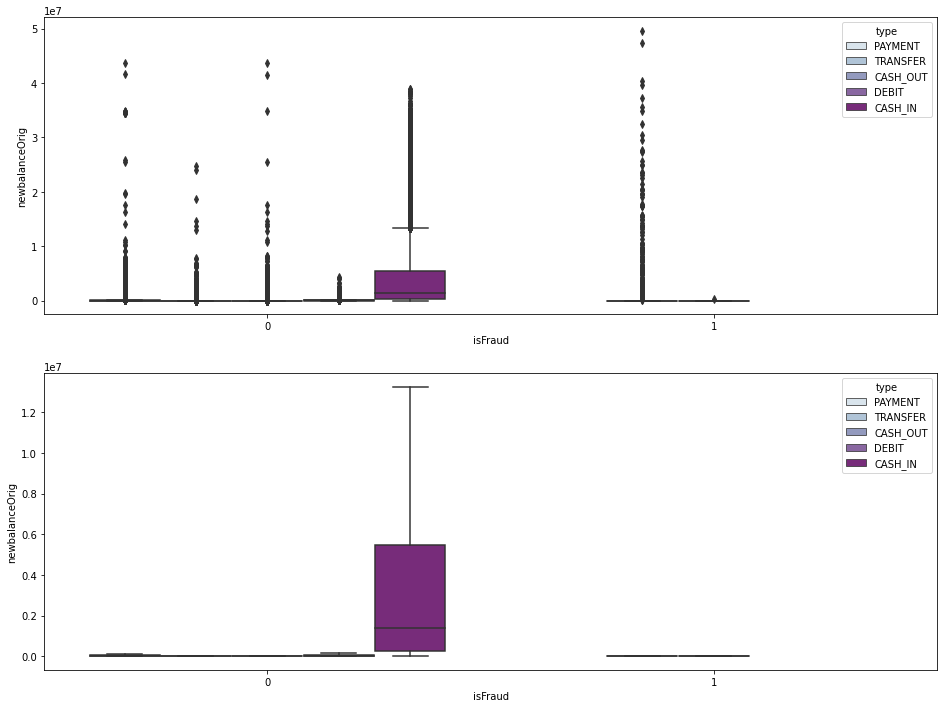

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="newbalanceOrig", hue="type",data=transactions, palette="BuPu",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="newbalanceOrig", hue="type",data=transactions, palette="BuPu",showfliers=False)
plt.show()

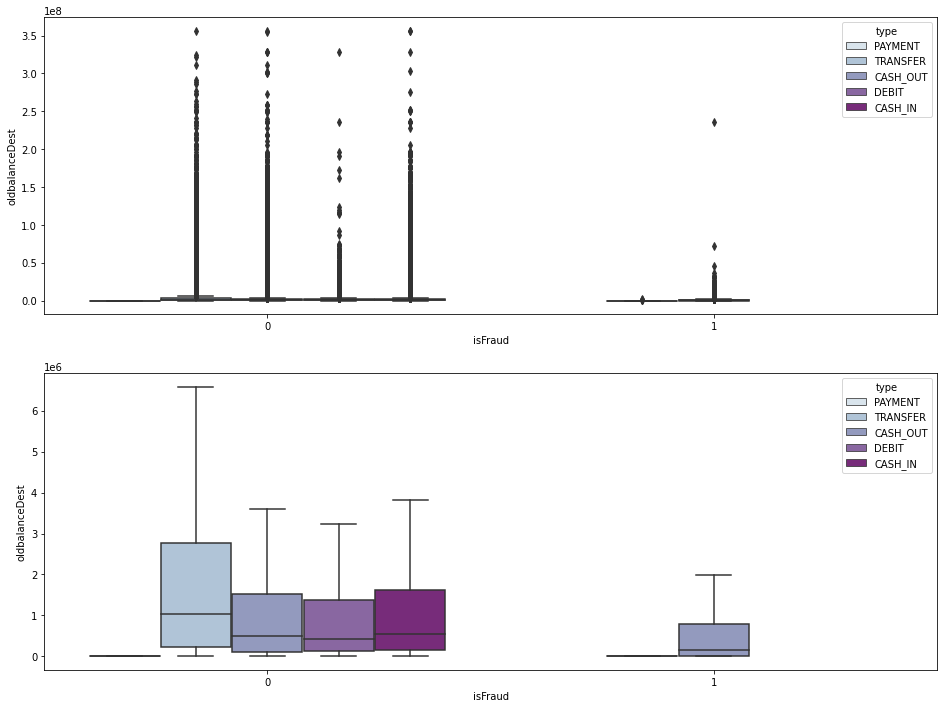

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="oldbalanceDest", hue="type",data=transactions, palette="BuPu",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="oldbalanceDest", hue="type",data=transactions, palette="BuPu",showfliers=False)
plt.show()

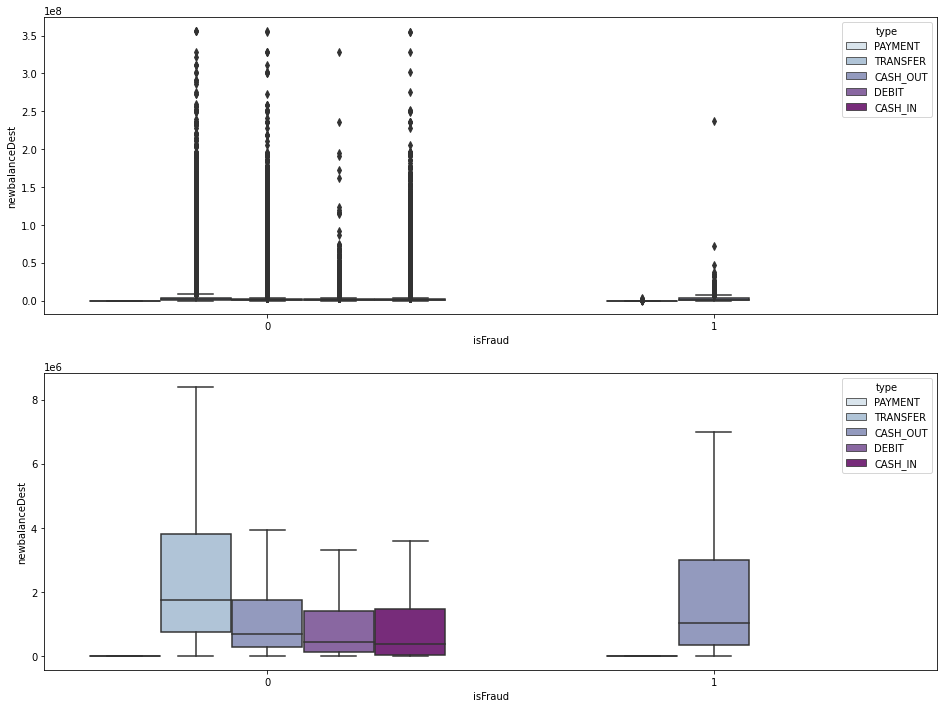

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,12))
s = sns.boxplot(ax = ax1, x="isFraud", y="newbalanceDest", hue="type",data=transactions, palette="BuPu",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="newbalanceDest", hue="type",data=transactions, palette="BuPu",showfliers=False)
plt.show()

<AxesSubplot:>

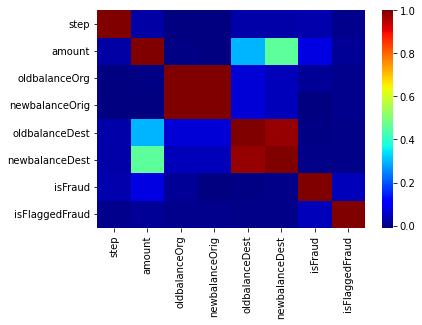

In [25]:
sns.heatmap(transactions.corr(), cmap='jet')

# Model

From the data, we will use 70% for training and 30% for validation.

CatBoostClassifier (CatBoost) algorithm is used.


In [26]:
#Since fraud has occured for type TRANSFER AND CASHOUT
X = transactions.loc[(transactions.type == 'TRANSFER') | (transactions.type == 'CASH_OUT')]
X.shape


(2770409, 11)

In [27]:
X.head()

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2      1  TRANSFER     181.00  C1305486145          181.0             0.0   
3      1  CASH_OUT     181.00   C840083671          181.0             0.0   
15     1  CASH_OUT  229133.94   C905080434        15325.0             0.0   
19     1  TRANSFER  215310.30  C1670993182          705.0             0.0   
24     1  TRANSFER  311685.89  C1984094095        10835.0             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2    C553264065             0.0            0.00        1               0  
3     C38997010         21182.0            0.00        1               0  
15   C476402209          5083.0        51513.44        0               0  
19  C1100439041         22425.0            0.00        0               0  
24   C932583850          6267.0      2719172.89        0               0

In [28]:
# Removing Unwanted columns

X = X.drop(['nameDest','nameOrig'], axis = 1)
X.shape

(2770409, 9)

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [29]:
#Adding New Features to Dataset
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest
X.shape

(2770409, 11)

In [30]:
#Convert 'TRANSFER' and 'CASh_OUT' to numerals
X['type'].replace('TRANSFER', 0, inplace = True)
X['type'].replace('CASH_OUT', 1, inplace = True)

In [31]:
X.head(10)

step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00         181.00             0.0             0.0   
3      1     1     181.00         181.00             0.0         21182.0   
15     1     1  229133.94       15325.00             0.0          5083.0   
19     1     0  215310.30         705.00             0.0         22425.0   
24     1     0  311685.89       10835.00             0.0          6267.0   
42     1     1  110414.71       26845.41             0.0        288800.0   
47     1     1   56953.90        1942.02             0.0         70253.0   
48     1     1    5346.89           0.00             0.0        652637.0   
51     1     1   23261.30       20411.53             0.0         25742.0   
58     1     0   62610.80       79114.00         16503.2           517.0   

    newbalanceDest  isFraud  isFlaggedFraud  errorBalanceOrig  \
2             0.00        1               0              0.00   
3             0.00        1               0              0.00   
15        51513.44        0               0         213808.94   
19            0.00        0               0         214605.30   
24      2719172.89        0               0         300850.89   
42         2415.16        0               0          83569.30   
47        64106.18        0               0          55011.88   
48      6453430.91        0               0           5346.89   
51            0.00        0               0           2849.77   
58         8383.29        0               0              0.00   

    errorBalanceDest  
2             181.00  
3           21363.00  
15         182703.50  
19         237735.30  
24       -2401220.00  
42         396799.55  
47          63100.72  
48       -5795447.02  
51          49003.30  
58          54744.51

In [32]:
#Checiking the No of Fraud cases in New Datasets
X['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [33]:
# Prearing Datasets
Y = X['isFraud'] # Target Variable

X = X.drop(['isFraud'], axis = 1) # Removing target variable
print("Shape of x: ", X.shape)
print("Shape of y: ", Y.shape)

Shape of x:  (2770409, 10)
Shape of y:  (2770409,)


In [34]:
X.head(4)

step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2      1     0     181.00          181.0             0.0             0.0   
3      1     1     181.00          181.0             0.0         21182.0   
15     1     1  229133.94        15325.0             0.0          5083.0   
19     1     0  215310.30          705.0             0.0         22425.0   

    newbalanceDest  isFlaggedFraud  errorBalanceOrig  errorBalanceDest  
2             0.00               0              0.00             181.0  
3             0.00               0              0.00           21363.0  
15        51513.44               0         213808.94          182703.5  
19            0.00               0         214605.30          237735.3

In [35]:
Y.head(4)

2     1
3     1
15    0
19    0
Name: isFraud, dtype: int64

In [36]:
#we use under-sampling because Smote will generate syntheticdata which is not desirable
#NCR is best for our application (accuracy)
from imblearn.under_sampling import NeighbourhoodCleaningRule
method = NeighbourhoodCleaningRule()
X_resampled, y_resampled = method.fit_resample(X, Y)

print("Shape of X: ", X_resampled.shape)
print("Shape of Y:", y_resampled.shape)


Shape of X:  (2765408, 10)
Shape of Y: (2765408,)


### Split data into test and validate

In [37]:

from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42) #42 is the answer to life the universe and everything :)


In [38]:
#check shapes
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)

print("Shape of x_validation: ", x_validation.shape)
print("Shape of y_validation: ", y_validation.shape)

Shape of x_train:  (1935785, 10)
Shape of y_train:  (1935785,)
Shape of x_validation:  (829623, 10)
Shape of y_validation:  (829623,)


In [39]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_validation = sc.transform(x_validation)

In [40]:
from xgboost import XGBRegressor, XGBClassifier
#model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=2)
model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=2)


In [41]:
%%time
model.fit(x_train, y_train)

C:\Users\neave\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 14 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=20, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Use the y_train labels to check how well the model was trained

In [42]:
x_preds = model.predict(x_train)

In [43]:
from sklearn.metrics import average_precision_score
auprc = average_precision_score(y_train, x_preds)
print("The Area under Precision Recall Curve Score For x_train is", auprc)

The Area under Precision Recall Curve Score For x_train is 0.996528557456651


#### Evaluate predictions

In [44]:
y_preds = model.predict(x_validation)
auprc = average_precision_score(y_validation, y_preds)
print("The Area under Precision Recall Curve Score For y_train is", auprc)

The Area under Precision Recall Curve Score For y_train is 0.9943442657345263


In [45]:
X.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud',
       'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')

make model file

In [46]:
import pickle
 
# Save the model as a pickle in a file
pickle.dump(model, open('XGBfraudModelv1.pkl', 'wb'))

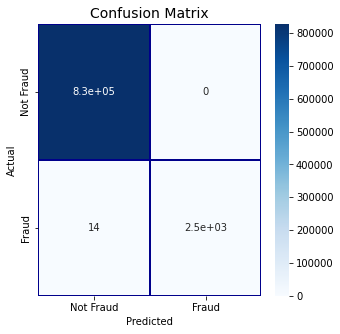

In [47]:
cm = pd.crosstab(y_validation.values, y_preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [48]:
# Print the classifcation report and confusion matrix
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

print('Classification report:\n', classification_report(y_validation, y_preds))
print("r**2 score: " + str(r2_score(y_validation, y_preds)))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    827155
           1       1.00      0.99      1.00      2468

    accuracy                           1.00    829623
   macro avg       1.00      1.00      1.00    829623
weighted avg       1.00      1.00      1.00    829623

r**2 score: 0.994310465114126
